## Model training for 5 year predictions


The predictions are later used as a recommendation for the long-term conditions. The model is trained on the monthly dataset

In [1]:
import pandas as pd
import numpy as np

Load data

In [ ]:
def load_and_clean_data(filepath, index_col=0, drop_cols=None, start_date="1926-07-31"):

    df = pd.read_csv(filepath, index_col=index_col, parse_dates=True)
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    df.dropna(inplace=True)
    return df.loc[start_date:].copy()

sp500 = load_and_clean_data("data/sp_monthly.csv")

rf = load_and_clean_data("data/fama_monthly.csv", 5, drop_cols=['mktrf', 'smb', 'hml', 'umd'])

# Combine the two DataFrames on their index
df = sp500.join(rf, how='inner')


df

,spindx,sprtrn,rf
caldt,,,
1926-07-31,12.88,0.045455,0.0022
1926-08-31,13.10,0.017081,0.0025
1926-09-30,13.40,0.022901,0.0023
1926-10-30,12.98,-0.031343,0.0032
1926-11-30,13.27,0.022342,0.0031
...,...,...,...
2024-08-30,5648.40,0.022835,0.0048
2024-09-30,5762.48,0.020197,0.0040
2024-10-31,5705.45,-0.009897,0.0039


plot performance of S&P 500

<Axes: xlabel='caldt'>

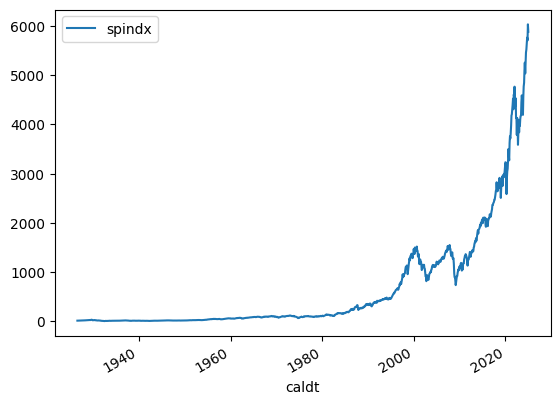

In [3]:
df.plot.line(y="spindx", use_index=True)

Compute log returns for simpler calculations in the future

In [4]:
# Convert simple S&P500 returns to log returns
df['sp_log_rtrn'] = np.log(1 + df['sprtrn'])

# Convert risk-free rate to log returns
df['rf_log_rtrn'] = np.log(1 + df['rf'])

# Calculate the excess log return
df['excess_log_rtrn'] = df['sp_log_rtrn'] - df['rf_log_rtrn']

# Optionally, drop the first row if you do not need the NaN value that results from the difference
df.dropna(inplace=True)

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn
caldt,,,,,,
1926-07-31,12.88,0.045455,0.0022,0.044452,0.002198,0.042255
1926-08-31,13.10,0.017081,0.0025,0.016937,0.002497,0.014440
1926-09-30,13.40,0.022901,0.0023,0.022643,0.002297,0.020345
1926-10-30,12.98,-0.031343,0.0032,-0.031845,0.003195,-0.035040
1926-11-30,13.27,0.022342,0.0031,0.022096,0.003095,0.019001
...,...,...,...,...,...,...
2024-08-30,5648.40,0.022835,0.0048,0.022578,0.004789,0.017790
2024-09-30,5762.48,0.020197,0.0040,0.019996,0.003992,0.016004
2024-10-31,5705.45,-0.009897,0.0039,-0.009946,0.003892,-0.013839


Compute Standard deviation and expected returns with a rolling window

In [5]:
horizon = 180 # 15 years of monthly data

rolling_var = df["sp_log_rtrn"].rolling(horizon).var()
rolling_expected_rtrn = df["sp_log_rtrn"].rolling(horizon).mean()
rolling_expected_rf = df["rf_log_rtrn"].rolling(horizon).mean()

df['rolling_var'] = rolling_var
df['rolling_expected_rtrn'] = rolling_expected_rtrn
df['rolling_expected_rf'] = rolling_expected_rf  

Create a target variable by comparing if the S&P 500 of the risk-free rate will have a better performance during the next 3 months.

In [6]:
# Define the forward-looking window
window = 60

# Compute the forward cumulative log returns using a reversed rolling sum:
df['sp_cum_log_rtrn'] = df['sp_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1].shift(-1)
df['rf_cum_log_rtrn'] = df['rf_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1].shift(-1)

# Create the Target variable: 1 if the S&P 500 cumulative log return is higher than the risk-free rate, else 0
df['Target'] = (df['sp_cum_log_rtrn'] > df['rf_cum_log_rtrn']).astype(int)

df.dropna(inplace=True)

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,rf_cum_log_rtrn,Target
caldt,,,,,,,,,,,,
1941-06-30,9.85,0.053476,0.0000,0.052095,0.000000,0.052095,0.009116,-0.001243,0.001014,0.626508,0.015298,1
1941-07-31,10.39,0.054822,0.0003,0.053372,0.000300,0.053072,0.009121,-0.001194,0.001003,0.547304,0.015298,1
1941-08-30,10.30,-0.008662,0.0001,-0.008700,0.000100,-0.008800,0.009120,-0.001336,0.000990,0.480266,0.015498,1
1941-09-30,10.20,-0.009709,0.0001,-0.009756,0.000100,-0.009856,0.009117,-0.001516,0.000978,0.382992,0.015698,1
1941-10-31,9.50,-0.068627,0.0000,-0.071095,0.000000,-0.071095,0.009139,-0.001734,0.000960,0.446034,0.015998,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30,2926.46,-0.018092,0.0016,-0.018258,0.001599,-0.019856,0.001632,0.005415,0.001052,0.657579,0.108799,1
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.660540,0.110992,1
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.630367,0.113286,1


Check window size which always contains both classes for target variable (0 and 1)

In [7]:
window = 246
invalid_window_found = False 

# Slide the window one step at a time
for i in range(len(df) - window + 1):
    window_values = df['Target'].iloc[i:i+window].values
    
    # Check if this window does NOT contain both 0 and 1
    if not (0 in window_values and 1 in window_values):
        invalid_window_found = True
        break  # no need to test further if one invalid window is found

print("Invalid window found: ", invalid_window_found)


Invalid window found:  False


## Add Technical Indicators

Average Price (Moving Average)

In [8]:
new_predictors = []

ma_horizons = [4, 21, 55]

for horizon in ma_horizons:
    rolling_means = df["spindx"].rolling(horizon).mean()
    ratio_column = f"ma_ratio_{horizon}"
    df[ratio_column] = df["spindx"] / rolling_means  # Use the Series directly

    new_predictors += [ratio_column]



Volatility

In [9]:
# Compute the 10-day volatility (rolling standard deviation)
df['volatility_10'] = df['spindx'].rolling(window=10).std()

new_predictors.append('volatility_10')


Moving average convergence divergence (MACD)

In [10]:
# set parameters
n = 42 # slow EMA
m = 21 # fast EMA
p = 14  # signal line

# Calculate EMAs
df[f'slow_EMA_{n}'] = df['spindx'].ewm(span=n, adjust=False).mean()
df[f'fast_EMA_{m}'] = df['spindx'].ewm(span=m, adjust=False).mean()
df[f'signal_EMA_{p}'] = df['spindx'].ewm(span=p, adjust=False).mean()

df[f'slow_EMA_ratio{n}'] = df["spindx"] / df[f'slow_EMA_{n}']
df[f'fast_EMA_ratio{m}'] = df["spindx"] / df[f'fast_EMA_{m}']
df[f'signal_EMA_ratio{p}'] = df["spindx"] / df[f'signal_EMA_{p}']

# Compute MACD and Signal line
df['MACD'] = df[f'fast_EMA_{m}'] - df[f'slow_EMA_{n}']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Add new predictors to the list
new_predictors += [f'slow_EMA_ratio{n}', f'fast_EMA_ratio{m}', f'signal_EMA_ratio{p}', 'MACD']#, 'MACD_Strategy', 'TEMA_Strategy']

Momentum

In [11]:
momentum_periods = [12, 25, 63]  

for period in momentum_periods:
    diff_column = f"momentum_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[diff_column] = df["spindx"] / (df["spindx"] - df["spindx"].shift(period))
    
    new_predictors.append(diff_column)

Rate of change (ROC):

In [12]:
for period in momentum_periods:
    roc_column = f"ROC_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[roc_column] = (df["spindx"] - df["spindx"].shift(period)) / df["spindx"].shift(period)
    
    new_predictors.append(roc_column)

Relative Strength Index (RSI)

In [13]:
rsi_periods = [25]

for period in rsi_periods:
    rsi_col = f"RSI_{period}"
    
    # Calculate Up and Down from daily log returns
    #    - 'Up' is the positive portion of the return
    #    - 'Down' is the positive portion of the negative return
    up = df['sp_log_rtrn'].clip(lower=0)
    down = -df['sp_log_rtrn'].clip(upper=0)
    
    # Compute rolling means of Up and Down over 'period' days
    #    (using a simple moving average for illustration)
    roll_up = up.rolling(window=period).mean()
    roll_down = down.rolling(window=period).mean()
    
    # Calculate the Relative Strength (RS) = average(Up) / average(Down)
    RS = roll_up / roll_down
    
    # Compute the RSI using the standard formula
    #    RSI = 100 - [ 100 / (1 + RS) ]
    df[rsi_col] = 100 - (100 / (1 + RS))
    
    new_predictors.append(rsi_col)


Detrended Price Oscillator (DPO):

In [14]:
dpo_periods = ma_horizons

for n in dpo_periods:
    # Calculate the shift for the SMA: (n//2) + 1
    shift_n = (n // 2) + 1
    
    # Compute the n-period Simple Moving Average
    sma_n = df['spindx'].rolling(window=n).mean()
    
    # Shift the SMA by shift_n periods
    sma_shifted = sma_n.shift(shift_n)
    
    # Compute DPO as the difference between today's price and the shifted SMA
    dpo_col = f"DPO_{n}"
    df[dpo_col] = df['spindx'] - sma_shifted
    
    # Optionally add the new DPO column to your list of predictors
    new_predictors.append(dpo_col)

Sharpe Ratio (SR):

In [15]:
rolling_window = 180  # 15 years of monthly data

# Compute the rolling Sharpe ratio: 
df[f'sharpe_{rolling_window}'] = df['excess_log_rtrn'].rolling(window=rolling_window).mean() / \
                                 df['sp_log_rtrn'].rolling(window=rolling_window).std()

new_predictors.append(f'sharpe_{rolling_window}')

Min/Max value over time prediction prior to period:

In [16]:
lookback_periods = [3, 12, 60] # 3 mohth, 1 year, 5 years

for period in lookback_periods:
    # Compute the rolling maximum and shift by one to exclude today's price.
    rolling_max = df["spindx"].rolling(window=period).max().shift(1)
    max_ratio_column = f"max_ratio_{period}"
    df[max_ratio_column] = df["spindx"] / rolling_max
    
    # Compute the rolling minimum and shift by one.
    rolling_min = df["spindx"].rolling(window=period).min().shift(1)
    min_ratio_column = f"min_ratio_{period}"
    df[min_ratio_column] = df["spindx"] / rolling_min
    
    new_predictors.extend([max_ratio_column, min_ratio_column])


Make sure that the last the reported date is always the last of the month

In [17]:
df.index = df.index.to_period('M').to_timestamp('M')
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,DPO_4,DPO_21,DPO_55,sharpe_180,max_ratio_3,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60
caldt,,,,,,,,,,,,,,,,,,,,,
1941-06-30,9.85,0.053476,0.0000,0.052095,0.000000,0.052095,0.009116,-0.001243,0.001014,0.626508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-07-31,10.39,0.054822,0.0003,0.053372,0.000300,0.053072,0.009121,-0.001194,0.001003,0.547304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-08-31,10.30,-0.008662,0.0001,-0.008700,0.000100,-0.008800,0.009120,-0.001336,0.000990,0.480266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-09-30,10.20,-0.009709,0.0001,-0.009756,0.000100,-0.009856,0.009117,-0.001516,0.000978,0.382992,...,NaN,NaN,NaN,NaN,0.981713,1.035533,NaN,NaN,NaN,NaN
1941-10-31,9.50,-0.068627,0.0000,-0.071095,0.000000,-0.071095,0.009139,-0.001734,0.000960,0.446034,...,NaN,NaN,NaN,NaN,0.914341,0.931373,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,2926.46,-0.018092,0.0016,-0.018258,0.001599,-0.019856,0.001632,0.005415,0.001052,0.657579,...,97.2650,332.917619,986.504545,0.107982,0.981908,1.063371,0.981908,1.167385,0.981908,1.524174
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.660540,...,108.2275,362.584762,1018.609273,0.108924,0.998779,1.017181,0.998779,1.187442,0.998779,1.550361
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.630367,...,132.5525,404.522381,1061.116000,0.109696,1.019185,1.037964,1.019185,1.211704,1.019185,1.582038


## Add Macro Vairables:

In [18]:
import glob
import pandas as pd
from pathlib import Path


file_paths = glob.glob("data/macro_variables/**/*.csv", recursive=True)

# list of tags whose raw data is daily (we’ll take a monthly average)
daily_tags = ['DGS10']  

# container for each variable’s monthly series
monthly_dfs = []

for path in file_paths:
    tag = Path(path).stem
    
    # Skip Crude Oil Prices as there is not enough data available
    # (it’s only available from 1986)
    if tag == 'DCOILWTICO':
        continue
    
    # read with col 0 as the index, parse it as dates
    temp = pd.read_csv(path, index_col=0, parse_dates=True)
    temp.columns = [f"{tag}_{col}" for col in temp.columns]
    
    if tag in daily_tags:
        # — for daily series: compute the mean of each calendar month,
        #   and timestamp it at month‑end
        temp = temp.resample('M').mean()
    else:
        # — for series observed on the 1st of each month:
        #   convert the 1st‑of‑month index to the last calendar day
        temp.index = temp.index.to_period('M').to_timestamp('M')
    
    # now every temp has a month‑end index; collect it
    monthly_dfs.append(temp)

# concatenate all of the monthly series side by side,
df_combined = pd.concat(monthly_dfs, axis=1).dropna()

df_combined


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_16332/3768614564.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp = temp.resample('M').mean()


,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,BAA_AAA_BAA_AAA
observation_date,,,,,
1962-01-31,4.083182,2.72,24.6496,30.040,0.66
1962-02-28,4.039444,2.73,25.0529,30.110,0.65
1962-03-31,3.930455,2.72,25.1873,30.170,0.65
1962-04-30,3.843000,2.73,25.2410,30.210,0.69
1962-05-31,3.873636,2.69,25.2141,30.240,0.72
...,...,...,...,...,...
2024-10-31,4.095455,4.51,102.2669,315.564,0.68
2024-11-30,4.355789,4.42,102.0231,316.449,0.64
2024-12-31,4.391429,4.27,103.1654,317.603,0.60


In [19]:
df = df.join(df_combined, how='inner')

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,BAA_AAA_BAA_AAA
1962-01-31,68.84,-0.037876,0.0024,-0.038612,0.002397,-0.041009,0.001259,0.008226,0.001440,0.229631,...,1.003206,0.962124,1.114276,0.962124,1.721430,4.083182,2.72,24.6496,30.040,0.66
1962-02-28,69.96,0.016270,0.0020,0.016139,0.001998,0.014141,0.001256,0.008398,0.001449,0.215453,...,1.016270,0.977778,1.102774,0.977778,1.749437,4.039444,2.73,25.0529,30.110,0.65
1962-03-31,69.55,-0.005860,0.0020,-0.005877,0.001998,-0.007875,0.001254,0.008460,0.001459,0.259983,...,1.010314,0.972048,1.075959,0.972048,1.739185,3.930455,2.72,25.1873,30.170,0.65
1962-04-30,65.24,-0.061970,0.0022,-0.063973,0.002198,-0.066171,0.001270,0.008325,0.001469,0.365328,...,0.947705,0.911810,1.009282,0.911810,1.631408,3.843000,2.73,25.2410,30.210,0.69
1962-05-31,59.63,-0.085990,0.0024,-0.089914,0.002397,-0.092311,0.001322,0.007875,0.001481,0.401375,...,0.914010,0.833403,0.922494,0.833403,1.491123,3.873636,2.69,25.2141,30.240,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,2926.46,-0.018092,0.0016,-0.018258,0.001599,-0.019856,0.001632,0.005415,0.001052,0.657579,...,1.063371,0.981908,1.167385,0.981908,1.524174,1.626364,1.95,102.7814,256.036,0.89
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.660540,...,1.017181,0.998779,1.187442,0.998779,1.550361,1.699500,1.89,102.4601,256.430,0.88
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.630367,...,1.037964,1.019185,1.211704,1.019185,1.582038,1.706818,1.65,101.5878,257.155,0.91
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.652607,...,1.073304,1.034047,1.252959,1.034047,1.635902,1.812105,1.54,102.1494,257.879,0.88


Change macro values from absolute to relative values by dividing the values with their moving average

In [20]:

horizon = 120 # 10 years of monthly data
absolute_cols = ['INDPRO_INDPRO', 'CPIAUCSL_CPIAUCSL', 'TB3MS_TB3MS', 'DGS10_DGS10']
macro_predictors = ['BAA_AAA_BAA_AAA']

for col in absolute_cols:
    rolling_means = df[f"{col}"].rolling(horizon).mean()
    ratio_column = f"{col}_ratio"
    df[ratio_column] = df[f"{col}"] / rolling_means  # Use the Series directly
    
    macro_predictors += [ratio_column]  

new_predictors = [p for p in new_predictors if p not in macro_predictors]

# Drop the original absolute columns
df.drop(columns=absolute_cols, inplace=True)
# Add the new macro predictors to your list
new_predictors += macro_predictors


Overview of all columns in the dataframe

In [21]:

df.dropna(inplace=True)

# print df column names
print(df.columns.tolist())

['spindx', 'sprtrn', 'rf', 'sp_log_rtrn', 'rf_log_rtrn', 'excess_log_rtrn', 'rolling_var', 'rolling_expected_rtrn', 'rolling_expected_rf', 'sp_cum_log_rtrn', 'rf_cum_log_rtrn', 'Target', 'ma_ratio_4', 'ma_ratio_21', 'ma_ratio_55', 'volatility_10', 'slow_EMA_42', 'fast_EMA_21', 'signal_EMA_14', 'slow_EMA_ratio42', 'fast_EMA_ratio21', 'signal_EMA_ratio14', 'MACD', 'Signal', 'momentum_rel_diff_12', 'momentum_rel_diff_25', 'momentum_rel_diff_63', 'ROC_rel_diff_12', 'ROC_rel_diff_25', 'ROC_rel_diff_63', 'RSI_25', 'DPO_4', 'DPO_21', 'DPO_55', 'sharpe_180', 'max_ratio_3', 'min_ratio_3', 'max_ratio_12', 'min_ratio_12', 'max_ratio_60', 'min_ratio_60', 'BAA_AAA_BAA_AAA', 'INDPRO_INDPRO_ratio', 'CPIAUCSL_CPIAUCSL_ratio', 'TB3MS_TB3MS_ratio', 'DGS10_DGS10_ratio']


Overview of all predictors that will be used to train the AI model

In [22]:
new_predictors

['ma_ratio_4',
 'ma_ratio_21',
 'ma_ratio_55',
 'volatility_10',
 'slow_EMA_ratio42',
 'fast_EMA_ratio21',
 'signal_EMA_ratio14',
 'MACD',
 'momentum_rel_diff_12',
 'momentum_rel_diff_25',
 'momentum_rel_diff_63',
 'ROC_rel_diff_12',
 'ROC_rel_diff_25',
 'ROC_rel_diff_63',
 'RSI_25',
 'DPO_4',
 'DPO_21',
 'DPO_55',
 'sharpe_180',
 'max_ratio_3',
 'min_ratio_3',
 'max_ratio_12',
 'min_ratio_12',
 'max_ratio_60',
 'min_ratio_60',
 'BAA_AAA_BAA_AAA',
 'INDPRO_INDPRO_ratio',
 'CPIAUCSL_CPIAUCSL_ratio',
 'TB3MS_TB3MS_ratio',
 'DGS10_DGS10_ratio']

## Initialize the model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# n_estimators: number of individual trees we want to train. The higher the number, the more accurate the model will be (up to a limit).
# min_samples_split: protects from overfitting (random forests tend to overfit by building deep trees). The higher the number, the less overfitting but also less accuracy.
model = RandomForestClassifier(n_estimators=500, min_samples_split=10, random_state=42)

In [24]:
def predict(train, test, predictors, model):
    """
    Predict the target variable using the given model and predictors.
    """
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])
    
    # Make predictions on the test data
    preds = model.predict_proba(test[predictors])[:,1]  # Get the probability that the stock goes up

    # Calculate the precision score #
    pred_prob = pd.Series(preds.copy(), index=test.index, name="Pred_probability")
    
    #set a high threshold for the prediction to be true
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Risk Aversion Coefficient Calculation #
    risk_aversion_vals = (test['rolling_expected_rtrn'] * 100 - test['rolling_expected_rf'] * 100) / ((pred_prob) * 100 * df['rolling_var'])
    risk_aversion = pd.Series(risk_aversion_vals, index=test.index, name="risk_aversion_coefficient")

    # 6. Combine everything into a single DataFrame
    combined = pd.concat([test["Target"], preds, pred_prob, risk_aversion], axis=1)

    
    # Return predictions as a Series with the same index as the test data
    return combined

In [25]:
def backtest(data, model, predictors, start=180, step=3):
    """
    Backtest the model on the given data.
    Parameters:
        data (DataFrame): The data to backtest on.
        model: The model to use for predictions.
        predictors (list): The list of predictor columns.
        start (int): The starting index for the backtest. Every trading year has around 250 trading days.
        2500 is around 10 years. Train first model on 10 years of data.
        step (int): The step size for the backtest. Train a model every 250 days (1 trading year).
    """
    # list of dataframes where each dataframe is a prediction for a single year
    all_predictions = []
    
    # for i in range(start, data.shape[0], step):
    #     # Split the data into training and testing sets -> training set is all the years prior to the current year, gets bigger with each iteration
    #     train = data.iloc[:i].copy() # all the years prior to the current year
    #     test = data.iloc[i:i + step].copy() # the current year
        
    for i in range(0, data.shape[0] - start - step + 1, step):
        # The training set always consists of exactly 'window' entries.
        train = data.iloc[i : i + start].copy()
        # The testing set consists of the next 'step' entries.
        test = data.iloc[i + start : i + start + step].copy()
        
        # Make predictions using the predict function
        preds = predict(train, test, predictors, model)
        
        # Append predictions to the list
        all_predictions.append(preds)
    
    # Concatenate all predictions into a single DataFrame
    results = pd.concat(all_predictions)
    return results

Clean data and remove very low or high values

In [26]:
# Replace infinities with NaNs first
df[new_predictors] = df[new_predictors].replace([np.inf, -np.inf], np.nan)

# Forward fill, then backward fill as a fallback:
df[new_predictors] = df[new_predictors].fillna(method='ffill')


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_16332/2907752904.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[new_predictors] = df[new_predictors].fillna(method='ffill')


In [27]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,BAA_AAA_BAA_AAA,INDPRO_INDPRO_ratio,CPIAUCSL_CPIAUCSL_ratio,TB3MS_TB3MS_ratio,DGS10_DGS10_ratio
1971-12-31,102.09,0.086179,0.0037,0.082666,0.003693,0.078973,0.001320,0.004349,0.003120,0.051264,...,1.086179,0.982107,1.107868,0.942050,1.403878,1.13,1.174881,1.208471,0.884689,1.134404
1972-01-31,103.94,0.018121,0.0029,0.017959,0.002896,0.015063,0.001308,0.004685,0.003122,-0.018546,...,1.105862,0.999904,1.105862,0.959122,1.429318,1.04,1.198395,1.208108,0.744794,1.135097
1972-02-29,106.57,0.025303,0.0025,0.024988,0.002497,0.022491,0.001302,0.005009,0.003122,-0.065432,...,1.133844,1.025204,1.133844,0.983390,1.465484,0.96,1.205904,1.210633,0.704523,1.156797
1972-03-31,107.20,0.005912,0.0027,0.005895,0.002696,0.003198,0.001301,0.004933,0.003124,-0.085451,...,1.050054,1.005912,1.140547,0.989204,1.474147,1.00,1.209631,1.207329,0.819690,1.150545
1972-04-30,107.67,0.004384,0.0029,0.004374,0.002896,0.001479,0.001296,0.004756,0.003127,-0.089623,...,1.035886,1.004384,1.145547,0.993541,1.480611,0.94,1.216840,1.206933,0.813834,1.170060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,2926.46,-0.018092,0.0016,-0.018258,0.001599,-0.019856,0.001632,0.005415,0.001052,0.657579,...,1.063371,0.981908,1.167385,0.981908,1.524174,0.89,1.042922,1.086032,3.794389,0.660681
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.660540,...,1.017181,0.998779,1.187442,0.998779,1.550361,0.88,1.038338,1.086145,3.575032,0.694393
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.630367,...,1.037964,1.019185,1.211704,1.019185,1.582038,0.91,1.028281,1.087656,3.045217,0.701397
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.652607,...,1.073304,1.034047,1.252959,1.034047,1.635902,0.88,1.032728,1.089158,2.778530,0.748742


Define function to report and evaluate the model

In [28]:
from sklearn.metrics import precision_score

def report_predictions(predictions):
    
    print("========== MODEL REPORTING ==========\n")
    
    # 1) Distribution of predicted classes
    print("1) Predictions value counts:")
    print(predictions["Predictions"].value_counts(), "\n")
    
    # 2) Precision of the positive class (1)
    prec = precision_score(predictions["Target"], predictions["Predictions"])
    print(f"2) Precision score (Target vs. Predictions): {prec:.4f}\n")
    
    # 3) Proportion of each true class in the sample
    print("3) Target class proportions:")
    print((predictions["Target"].value_counts() / len(predictions)).rename("proportion"), "\n")
    
    # 4) Median predicted probability (from your monthly model)
    med_prob = predictions["Pred_probability"].median()
    print(f"4) Median prediction probability: {med_prob:.4f}\n")
    
    print("======================================")

## Balanced AI model

Find the time period in the dataset where most balanced data is available, e.g. similar amount of days where the S&P 500 ourperforms (1) and where one month treasury bills outperform (2)

In [29]:
import pandas as pd

window=180
cutoff_date='1995-01-01'

# Ensure sorted index
df = df.sort_index()

# Build 0/1 mask
zero_mask = (df['Target'] == 0).astype(int)

# FULL dataset rolling sums
rolling_all = zero_mask.rolling(window=window, min_periods=window).sum()

# Pre‑cutoff dataset and its rolling sums
df_pre = df.loc[df.index < cutoff_date]
zero_mask_pre = zero_mask.loc[df_pre.index]
rolling_pre = zero_mask_pre.rolling(window=window, min_periods=window).sum()

# Best window before cutoff
max_zeros_pre = int(rolling_pre.max())
end_pre       = rolling_pre.idxmax()
end_pos_pre   = df_pre.index.get_indexer([end_pre])[0]
start_pos_pre = end_pos_pre - window + 1
start_pre     = df_pre.index[start_pos_pre]

# Mean & median in pre‑cutoff
mean_pre   = rolling_pre.mean()
median_pre = rolling_pre.median()

# Mean & median in full dataset
mean_all   = rolling_all.mean()
median_all = rolling_all.median()

print("===== Zero‐Count Analysis =====")
print(f"Window size: {window} rows\n")

print(f"1) Before {cutoff_date}:")
print(f"   • Max zeros in any window: {max_zeros_pre}")
print(f"     Period: {start_pre.date()} through {end_pre.date()}")
print(f"   • Mean zeros per window:   {mean_pre:.2f}")
print(f"   • Median zeros per window: {median_pre:.2f}\n")

print("2) Entire dataset:")
print(f"   • Mean zeros per window:   {mean_all:.2f}")
print(f"   • Median zeros per window: {median_all:.2f}")

===== Zero‐Count Analysis =====
Window size: 180 rows

1) Before 1995-01-01:
   • Max zeros in any window: 88
     Period: 1971-12-31 through 1986-11-30
   • Mean zeros per window:   50.42
   • Median zeros per window: 53.00

2) Entire dataset:
   • Mean zeros per window:   57.10
   • Median zeros per window: 53.00


Train the model using biased data and make predictions on the dataframe entries relevant for the study

In [30]:
preds_balanced = predict(df.loc['1971-12-31':'1986-11-30'], df.iloc[-300:], new_predictors, model)

In [31]:
preds_balanced

,Target,Predictions,Pred_probability,risk_aversion_coefficient
1995-01-31,1,1.0,0.514630,1.869260
1995-02-28,1,1.0,0.551639,1.971822
1995-03-31,1,1.0,0.576511,2.688422
1995-04-30,1,1.0,0.619798,2.483378
1995-05-31,1,1.0,0.684120,2.222955
...,...,...,...,...
2019-08-31,1,1.0,0.688093,3.884094
2019-09-30,1,1.0,0.690063,3.906011
2019-10-31,1,1.0,0.701603,3.868001
2019-11-30,1,1.0,0.725369,3.725475


In [32]:
report_predictions(preds_balanced)

========== MODEL REPORTING ==========

1) Predictions value counts:
Predictions
1.0    254
0.0     46
Name: count, dtype: int64 

2) Precision score (Target vs. Predictions): 0.6969

3) Target class proportions:
Target
1    0.666667
0    0.333333
Name: proportion, dtype: float64 

4) Median prediction probability: 0.6730



## Unbalanced AI model

Find time series data with unbalanced data, e.g. with as many periods of S&P 500 outperformance (1) as possible

In [33]:
import pandas as pd

window = 180
cutoff_date = '1995-01-01'

# Ensure sorted index
df = df.sort_index()

# Build 0/1 mask
zero_mask = (df['Target'] == 0).astype(int)

# FULL dataset rolling sums
rolling_all = zero_mask.rolling(window=window, min_periods=window).sum()

# Pre-cutoff dataset and its rolling sums
df_pre = df.loc[df.index < cutoff_date]
zero_mask_pre = zero_mask.loc[df_pre.index]
rolling_pre = zero_mask_pre.rolling(window=window, min_periods=window).sum()

# Least-zero window before cutoff
min_zeros_pre   = int(rolling_pre.min())
end_pre_min     = rolling_pre.idxmin()
end_pos_pre_min = df_pre.index.get_indexer([end_pre_min])[0]
start_pos_pre_min = end_pos_pre_min - window + 1
start_pre_min   = df_pre.index[start_pos_pre_min]

# Mean & median in pre-cutoff (unchanged)
mean_pre   = rolling_pre.mean()
median_pre = rolling_pre.median()

# Least-zero window in full dataset
min_zeros_all   = int(rolling_all.min())
end_all_min     = rolling_all.idxmin()
end_pos_all_min = df.index.get_indexer([end_all_min])[0]
start_pos_all_min = end_pos_all_min - window + 1
start_all_min   = df.index[start_pos_all_min]

# Mean & median in full dataset (unchanged)
mean_all   = rolling_all.mean()
median_all = rolling_all.median()

# REPORT
print("===== Zero-Count Analysis (Least zeros) =====")
print(f"Window size: {window} rows\n")

print(f"1) Before {cutoff_date}:")
print(f"   • Min zeros in any window: {min_zeros_pre}")
print(f"     Period: {start_pre_min.date()} through {end_pre_min.date()}")
print(f"   • Mean zeros per window:   {mean_pre:.2f}")
print(f"   • Median zeros per window: {median_pre:.2f}\n")

print("2) Entire dataset:")
print(f"   • Min zeros in any window: {min_zeros_all}")
print(f"     Period: {start_all_min.date()} through {end_all_min.date()}")
print(f"   • Mean zeros per window:   {mean_all:.2f}")
print(f"   • Median zeros per window: {median_all:.2f}")

# Optional: extract the least-zero slices
best_slice_pre_min = df_pre.loc[start_pre_min:end_pre_min]
best_slice_all_min = df.loc[start_all_min:end_all_min]


===== Zero-Count Analysis (Least zeros) =====
Window size: 180 rows

1) Before 1995-01-01:
   • Min zeros in any window: 12
     Period: 1980-01-31 through 1994-12-31
   • Mean zeros per window:   50.42
   • Median zeros per window: 53.00

2) Entire dataset:
   • Min zeros in any window: 4
     Period: 1981-01-31 through 1995-12-31
   • Mean zeros per window:   57.10
   • Median zeros per window: 53.00


In [34]:
preds_unbalanced = predict(df.loc['1980-01-31':'1994-12-31'], df.iloc[-300:], new_predictors, model)

In [35]:
report_predictions(preds_unbalanced)

========== MODEL REPORTING ==========

1) Predictions value counts:
Predictions
1.0    264
0.0     36
Name: count, dtype: int64 

2) Precision score (Target vs. Predictions): 0.7576

3) Target class proportions:
Target
1    0.666667
0    0.333333
Name: proportion, dtype: float64 

4) Median prediction probability: 0.6750



## Export both prediction dataframes as CSV

In [36]:
preds_balanced

,Target,Predictions,Pred_probability,risk_aversion_coefficient
1995-01-31,1,1.0,0.514630,1.869260
1995-02-28,1,1.0,0.551639,1.971822
1995-03-31,1,1.0,0.576511,2.688422
1995-04-30,1,1.0,0.619798,2.483378
1995-05-31,1,1.0,0.684120,2.222955
...,...,...,...,...
2019-08-31,1,1.0,0.688093,3.884094
2019-09-30,1,1.0,0.690063,3.906011
2019-10-31,1,1.0,0.701603,3.868001
2019-11-30,1,1.0,0.725369,3.725475


In [37]:
preds_unbalanced

,Target,Predictions,Pred_probability,risk_aversion_coefficient
1995-01-31,1,1.0,1.000000,0.961978
1995-02-28,1,1.0,0.993173,1.095211
1995-03-31,1,1.0,0.986824,1.570598
1995-04-30,1,1.0,0.943539,1.631297
1995-05-31,1,1.0,0.892128,1.704653
...,...,...,...,...
2019-08-31,1,1.0,0.638808,4.183756
2019-09-30,1,1.0,0.623523,4.322847
2019-10-31,1,1.0,0.615745,4.407344
2019-11-30,1,1.0,0.592765,4.558881


In [38]:
diff_idx = preds_balanced.index.symmetric_difference(
    preds_unbalanced.index
)
print("Dates not in both frames:")
print(diff_idx)

Dates not in both frames:
DatetimeIndex([], dtype='datetime64[ns]', freq='ME')


In [39]:
import uuid
import pandas as pd

def transform_for_db(
    daily_trading_df: pd.DataFrame,
    monthly_pred_df: pd.DataFrame,
    scenario_id: str
) -> pd.DataFrame:
 
    # Build a full calendar of days from first to last trading date
    cal_idx = pd.date_range(
        start=daily_trading_df.index.min(),
        end  =daily_trading_df.index.max(),
        freq ='D',
        name =daily_trading_df.index.name
    )

    # Reindex & forward‑fill so every calendar day has the last known value
    daily_full = daily_trading_df.reindex(cal_idx).ffill()

    # Keep only real trading days plus every month‑end
    month_ends = pd.date_range(
        start=daily_trading_df.index.min(),
        end  =daily_trading_df.index.max(),
        freq ='M'
    )
    allowed_idx = daily_trading_df.index.union(month_ends)
    daily_plus_me = daily_full.loc[allowed_idx]

    # Join the two cum‑return series onto the monthly predictions
    merged = monthly_pred_df.join(
        daily_plus_me[['sp_cum_log_rtrn','rf_cum_log_rtrn']],
        how='left'
    ).copy()

    # Compute fund allocations: first *100, cast to int for fund_b, then subtract from 100 for fund_a
    merged['fund_b'] = (merged['Pred_probability'] * 100).astype(int)
    merged['fund_a'] = 100 - merged['fund_b']

    # Rename return columns and drop originals + unneeded cols
    merged = (
        merged
        .rename(columns={
            'sp_cum_log_rtrn':'return_b',
            'rf_cum_log_rtrn':'return_a'
        })
        .drop(columns=[
            'Target','Predictions',
            'Pred_probability','risk_aversion_coefficient'
        ])
    )

    # Insert a trial_number 1…N as the first column
    merged.insert(0, 'trial_number', range(1, len(merged) + 1))

    # Tag every row with the provided scenario_id
    merged['scenario_id'] = scenario_id

    # Add UUID columns for recommendation and fund return
    merged['recommendation_id'] = [uuid.uuid4() for _ in range(len(merged))]
    merged['fund_return_id'] = [uuid.uuid4() for _ in range(len(merged))]

    return merged


In [40]:
# insert the scenario_id from scenario_config database table
longterm_balanced = transform_for_db(df, preds_balanced, 'e25b48e9-4356-4c4c-8b05-94132af9dac1')
longterm_balanced

/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_16332/2598004481.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = pd.date_range(


,trial_number,return_b,return_a,fund_b,fund_a,scenario_id,recommendation_id,fund_return_id
1995-01-31,1,1.086638,0.249475,51,49,e25b48e9-4356-4c4c-8b05-94132af9dac1,b1edeadf-5a71-412e-a352-5f593bf09ea4,908d6fed-eac8-4cdf-86fd-03f23e7586c9
1995-02-28,2,1.030886,0.249774,55,45,e25b48e9-4356-4c4c-8b05-94132af9dac1,2127784b-124d-4909-8e13-759282fb6d92,ec878a43-945b-4fd7-bea9-e4d730a5ed63
1995-03-31,3,1.096248,0.249874,57,43,e25b48e9-4356-4c4c-8b05-94132af9dac1,07b6f9f1-1b42-49de-88e2-813863797e2a,486d7ff8-8c7a-49cd-9d9c-95fe82acbec4
1995-04-30,4,1.037391,0.250073,61,39,e25b48e9-4356-4c4c-8b05-94132af9dac1,8b6a4308-12cd-4097-8c83-fc147d91446f,758b90dd-1d62-4ab1-88c9-95410b24efda
1995-05-31,5,0.979564,0.249675,68,32,e25b48e9-4356-4c4c-8b05-94132af9dac1,3e442ef8-4318-432a-aeaf-fb0a8db49e17,6add03e7-4588-48cc-a1a7-ddb9008c5568
...,...,...,...,...,...,...,...,...
2019-08-31,296,0.657579,0.108799,68,32,e25b48e9-4356-4c4c-8b05-94132af9dac1,b180bfa9-8482-48c0-8253-242a9546ca2f,60730c4b-989a-4938-8ae7-f3bc77c6b1de
2019-09-30,297,0.660540,0.110992,69,31,e25b48e9-4356-4c4c-8b05-94132af9dac1,01bfe2ca-7a70-4e45-b167-a77f443d6790,9b038432-1c04-42cd-8f2a-166683753df4
2019-10-31,298,0.630367,0.113286,70,30,e25b48e9-4356-4c4c-8b05-94132af9dac1,5a94d77a-e7f9-4ea6-9335-ba25a046c27a,b42017d9-0e98-4b15-8fe7-0d053f114ef9
2019-11-30,299,0.652607,0.116079,72,28,e25b48e9-4356-4c4c-8b05-94132af9dac1,cab0e45c-8df5-4cd3-b328-d3b75c9c8dbd,c4efcee3-ddd5-486f-97f3-460024014f32


Check return behaviour for study tool performance chart scaling

In [41]:
# compute mins and maxes
print(longterm_balanced['return_a'].min())
print(longterm_balanced['return_a'].max())
print(longterm_balanced['return_b'].min())
print(longterm_balanced['return_b'].max())

0.0010999450036662706
0.2535558249720704
-0.4431122878774312
1.0962478679637293


In [42]:
longterm_unbalanced = transform_for_db(df, preds_unbalanced, '4438925c-5c3f-4773-aa1d-de52214915b1')

longterm_unbalanced

/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_16332/2598004481.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = pd.date_range(


,trial_number,return_b,return_a,fund_b,fund_a,scenario_id,recommendation_id,fund_return_id
1995-01-31,1,1.086638,0.249475,100,0,4438925c-5c3f-4773-aa1d-de52214915b1,cb454e53-9952-44c8-804c-50056f148fce,0ca78830-bf10-4f67-bd15-00d12890e969
1995-02-28,2,1.030886,0.249774,99,1,4438925c-5c3f-4773-aa1d-de52214915b1,f88fcd2b-c9da-479e-af9d-2e99a1522ab6,4f324fd6-a83e-46e3-97aa-7434abf88cb0
1995-03-31,3,1.096248,0.249874,98,2,4438925c-5c3f-4773-aa1d-de52214915b1,7c5e8ec5-6ea2-4a18-87da-60367a51713a,536d8a99-d01c-42df-873f-40e625034134
1995-04-30,4,1.037391,0.250073,94,6,4438925c-5c3f-4773-aa1d-de52214915b1,d06c79f4-9522-4649-b46f-df6451c06cb1,0c74f06e-14b0-4b03-b651-59558db384e5
1995-05-31,5,0.979564,0.249675,89,11,4438925c-5c3f-4773-aa1d-de52214915b1,81237269-702b-4e94-b2de-4ca835f7d482,abbd3ac5-23d3-4865-808e-82ff3d424eb7
...,...,...,...,...,...,...,...,...
2019-08-31,296,0.657579,0.108799,63,37,4438925c-5c3f-4773-aa1d-de52214915b1,80a6c918-1eec-4426-b488-9aa653126bbc,96295323-081f-4a90-bd8a-abd62b3c8b15
2019-09-30,297,0.660540,0.110992,62,38,4438925c-5c3f-4773-aa1d-de52214915b1,70333184-2914-4d88-b97f-c1752d1f2132,2e1fda0f-2e9d-435f-94f4-739a746e7dbd
2019-10-31,298,0.630367,0.113286,61,39,4438925c-5c3f-4773-aa1d-de52214915b1,d15f50a1-09f6-4266-83c6-b9be26952d51,55de07df-390c-469a-9689-23324261c7cc
2019-11-30,299,0.652607,0.116079,59,41,4438925c-5c3f-4773-aa1d-de52214915b1,7a150fd1-8838-48ef-a246-5596892e76e3,87a238b7-910d-4d73-8246-4dd1eac5b0d5


Check return behaviour for study tool performance chart scaling

In [43]:
# compute mins and maxes
print(longterm_unbalanced['return_a'].min())
print(longterm_unbalanced['return_a'].max())
print(longterm_unbalanced['return_b'].min())
print(longterm_unbalanced['return_b'].max())



0.0010999450036662706
0.2535558249720704
-0.4431122878774312
1.0962478679637293


export data

In [44]:
import os
import pandas as pd

def export_as_csv(
    export_df: pd.DataFrame,
    base_name: str
) -> None:
    """
    Exports two CSV files from `export_df` in data/output/:
      1) {base_name}_ai_recommendations.csv  → columns: scenario_id, trial_number, fund_a, fund_b
      2) {base_name}_fund_returns.csv        → columns: scenario_id, trial_number, return_a, return_b

    If the files already exist, they will be overwritten.
    
    Parameters
    ----------
    export_df : pd.DataFrame
        Must contain columns:
          ['scenario_id', 'trial_number', 'fund_a', 'fund_b', 'return_a', 'return_b']
    base_name : str
        Base filename (no extension), e.g. "biased_long"
    """
    # Build full paths
    ai_csv_path      = os.path.join("data", "output",  "ai_recommendations", f"{base_name}_ai_recommendations.csv")
    returns_csv_path = os.path.join("data", "output", "fund_returns", f"{base_name}_fund_returns.csv")

    # Ensure output directory exists
    os.makedirs(os.path.dirname(ai_csv_path), exist_ok=True)
    os.makedirs(os.path.dirname(returns_csv_path), exist_ok=True)

    # 1) Export AI recommendations (overwrites by default)
    ai_df = export_df[['scenario_id', 'recommendation_id',  'trial_number', 'fund_a', 'fund_b']]
    ai_df.to_csv(ai_csv_path, index=False)

    # 2) Export fund returns (overwrites by default)
    returns_df = export_df[['scenario_id', 'fund_return_id', 'trial_number', 'return_a', 'return_b']]
    returns_df.to_csv(returns_csv_path, index=False)

    print(f"Exported:\n - {ai_csv_path}\n - {returns_csv_path}")

In [45]:
export_as_csv(longterm_balanced, 'longterm_balanced')
export_as_csv(longterm_unbalanced, 'longterm_unbalanced')

Exported:
 - data/output/ai_recommendations/longterm_balanced_ai_recommendations.csv
 - data/output/fund_returns/longterm_balanced_fund_returns.csv
Exported:
 - data/output/ai_recommendations/longterm_unbalanced_ai_recommendations.csv
 - data/output/fund_returns/longterm_unbalanced_fund_returns.csv
